In [5]:
import verbose_module; import sys; import os
import matplotlib.pyplot as plt
import seaborn as sns; import pandas as pd
import numpy as np

from scipy.stats import ttest_rel
from pickle import load
from matplotlib.patches import Circle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append('../../.')
import pIRPgym


weights = [[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]] + [[0.5,0.1,0.1,0.2,0.1]] + [[round(i*0.1,4)]+[round((1-i*0.1)/4,4) for j in range(4)] for i in range(11)]

other_path = True

# Lookahead Decisions

In [6]:
from turtle import width


def load_lookahead_by_product(day, weights, seed_ix):

    la_decisions = verbose_module.import_results.import_lookahead_decisions(weights, seed_ix, other_path=other_path); la_decisions = la_decisions[day]
    inst_gen = verbose_module.import_results.import_instance_parameters(weights, seed_ix, other_path=other_path)

    norm_matrix = verbose_module.import_results.import_norm_matrix(weights, seed_ix, other_path=True);print(norm_matrix); print(norm_matrix[day]["costs"]); norm_matrix = norm_matrix[day]

    return la_decisions, inst_gen, norm_matrix

def plot_lookahead_day(day, t, k, ax, inventory, purchase, backorders, demand_compliance, inst_gen):

    w = {s:{i:1 if sum(purchase[s][i,kk] for kk in inst_gen.Products if i in inst_gen.M_kt[kk,day-1])>0 else 0 for i in inst_gen.Suppliers} for s in inst_gen.Samples}

    xlim = 9+2*len(inst_gen.Suppliers)+4+1
    ylim = 5+2*len(inst_gen.Samples)+1

    if t == 0: s = f"Day {day}"
    else: s = f"Day {day+t} lookahead"
    ax.text(x=1, y=ylim-1.5, s=s, va="center", ha="left", fontname="Century Gothic", fontsize=14)

    ax.text(x=(2*9+2*len(inst_gen.Suppliers))/2, y=2+2*len(inst_gen.Samples)+0.5, s="Supplier", va="center", ha="center", fontname="Century Gothic")
    for i in inst_gen.Suppliers:
        ax.text(x=8+2*i, y=1+2*len(inst_gen.Samples)+0.5, s=i, color="black" if i in inst_gen.M_kt[k,day-1] else "silver", va="center", ha="center", fontname="Century Gothic")
    
    ax.vlines(x=[3,7]+[9+2*i for i in range(len(inst_gen.Suppliers)+1)], ymin=1, ymax=1+2*len(inst_gen.Samples), color="black", lw=1)
    ax.hlines(y=[1+2*s for s in range(len(inst_gen.Samples)+1)], xmin=3,xmax=7, color="black", lw=1)
    ax.hlines(y=[1+2*s for s in range(len(inst_gen.Samples)+1)], xmin=9,xmax=9+2*len(inst_gen.Suppliers), color="black", lw=1)

    ax.hlines(y=[2+2*s for s in inst_gen.Samples], xmin=3.2, xmax=4.8, linestyle="--", color="navy", lw=0.5)

    ax.text(x=5, y=1+2*len(inst_gen.Samples)+0.5, s="Serv. Lev.", va="center", ha="center", fontname="Century Gothic")
    ax.text(x=1.5, y=(1+2*len(inst_gen.Samples))/2, s="Sample Path", va="center", ha="center", fontname="Century Gothic", rotation=90)
    for s in inst_gen.Samples[::-1]:
        yc = 2*(len(inst_gen.Samples)-s)
        ax.text(x=2.5, y=yc, s=s+1, va="center", ha="center", fontname="Century Gothic")

        dem_compl = sum(demand_compliance[s][k,o] for o in range(inst_gen.O_k[k]+1))
        dem = inst_gen.s_paths_d[day-1][t,s][k]; sl = dem_compl/dem
        ax.text(x=4, y=yc+0.5, s=round(dem_compl,1) , va="center", ha="center", fontname="Cambria", fontsize=9, color="navy")
        ax.text(x=4, y=yc-0.5, s=round(dem,1) , va="center", ha="center", fontname="Cambria", fontsize=9, color="navy")
        ax.text(x=6, y=yc, s=f"{sl:.1%}" if sl < 0.99 else "100%", va="center", ha="center", fontname="Cambria", fontsize=9, color="navy")

        for i in inst_gen.Suppliers:
            xc = 8+2*i
            if i in inst_gen.M_kt[k,day-1]:
                z = purchase[s][i,k]
                q = inst_gen.s_paths_q[day-1][t,s][i,k]
                col = "gold" if z == q else "white"
                ax.text(x=xc, y = yc+0.5, s=round(z,1), va="center", ha="center", fontname="Cambria", fontsize=9, color="navy" if z > 0 or w[s][i] else "white")
                ax.hlines(y=[yc], xmin=xc-0.8, xmax=xc+0.8, linestyle="--", color="navy" if not w[s][i] else "gold", lw=0.5)
                ax.text(x=xc, y = yc-0.5, s=round(q,1), va="center", ha="center", fontname="Cambria", fontsize=9, color="navy")
                ax.fill_between(x=[xc-1,xc+1], y1 = yc-1, y2 = yc+1, color=col)
                
            else:
                ax.text(x=xc, y = yc+0.5, s="-", va="center", ha="center", fontname="Cambria", fontsize=9, color="silver")
                ax.hlines(y=[yc], xmin=xc-0.8, xmax=xc+0.8, linestyle="--", color="silver", lw=0.5)
                ax.text(x=xc, y = yc-0.5, s="-", va="center", ha="center", fontname="Cambria", fontsize=9, color="silver")
            if w[s][i]:
                    ax.vlines(x=[xc-1, xc+1], ymin=yc-1, ymax=yc+1, color="gold", lw = 1)
                    ax.hlines(y=[yc-1, yc+1], xmin=xc-1, xmax=xc+1, color="gold", lw = 1)
        
        perished = inventory[s][k,inst_gen.O_k[k]]
        ax.vlines(x=[8+2*len(inst_gen.Suppliers)+3,8+2*len(inst_gen.Suppliers)+5], ymin=1, ymax=1+2*len(inst_gen.Samples), color="black", lw=0.5)
        ax.hlines(y=[1+2*s for s in range(len(inst_gen.Samples)+1)], xmin=8+2*len(inst_gen.Suppliers)+3, xmax=8+2*len(inst_gen.Suppliers)+5, color="black", lw=0.5)
        ax.text(x=8+2*len(inst_gen.Suppliers)+4, y=1+2*len(inst_gen.Samples)+0.5, s="Waste", va="center", ha="center", fontname="Century Gothic")
        ax.text(x=8+2*len(inst_gen.Suppliers)+4, y=yc, s=round(perished,1), color="navy" if perished == 0 else "crimson", va="center", ha="center", fontname="Cambria", fontsize=9)
    
    ax.set_xlim(0,xlim-0.5); ax.set_ylim(0,ylim)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines[["bottom","top","right"]].set_visible(False)


def plot_costs_of_product(day,k,ax,inst_gen,purchase,inventory,demand_compliance,backorders):

    w = {t:{s:{i:1 if sum(purchase[t][s][i,kk] for kk in inst_gen.Products if i in inst_gen.M_kt[kk,day-1])>0 else 0 for i in inst_gen.Suppliers} for s in inst_gen.Samples} for t in range(inst_gen.sp_window_sizes[day-1])}

    
    purch = {s:sum(inst_gen.W_p[day-1][i,k]*purchase[t][s][i,k] for i in inst_gen.M_kt[k,day-1] for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    hold = {s:sum(inst_gen.W_h[day-1][k]*inventory[t][s][k,o] for o in range(inst_gen.O_k[k]) for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    backo = {s:sum(inst_gen.back_o_cost[k]*backorders[t][s][k] for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    rout = {s:sum((inst_gen.c[0,i]+inst_gen.c[i,0])*purchase[t][s][i,k]/sum(purchase[t][s][i,kk] for kk in inst_gen.K_it[i,day-1]) if w[t][s][i] else 0 for i in inst_gen.M_kt[k,day-1] for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    ax.barh(y=1, width=sum(purch.values())/len(inst_gen.Samples), color="darkorange")
    ax.barh(y=1, width=sum(rout.values())/len(inst_gen.Samples), left=(sum(purch.values()))/len(inst_gen.Samples), color="purple")
    ax.barh(y=1, width=sum(backo.values())/len(inst_gen.Samples), left=(sum(purch.values())+sum(rout.values()))/len(inst_gen.Samples), color="crimson")
    if inst_gen.hold_cost: ax.barh(y=1, width=sum(hold.values())/len(inst_gen.Samples), left=(sum(purch.values())+sum(rout.values())+sum(backo.values()))/len(inst_gen.Samples), color="forestgreen")

    ax.set_title("Total Cost", fontname="Century Gothic", fontsize=12)
    ax.set_xlabel("$", fontname="Century Gothic")
    ax.set_yticks([]); ax.set_ylim(0,2)
    ax.spines[["top","right"]].set_visible(False); ax.invert_yaxis()
    ax.tick_params(axis='y', left=False, right=False, pad=0.5); ax.set_ylabel("Exp. Value", fontname="Century Gothic")


def plot_environmental_indicator_of_product(day,k,e,ax,inst_gen,purchase,inventory):

    transport = {s:sum((inst_gen.c_LCA[e][k][0,i]+inst_gen.c_LCA[e][k][i,0])*purchase[t][s][i,k] for i in inst_gen.M_kt[k,day-1] for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    storage = {s:sum(inst_gen.h_LCA[e][k]*inventory[t][s][k,o] for o in range(inst_gen.O_k[k]) for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    waste = {s:sum(inst_gen.waste_LCA[e][k]*inventory[t][s][k,inst_gen.O_k[k]] for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    ax.barh(y=1, width=sum(transport.values())/len(inst_gen.Samples), color="purple")
    ax.barh(y=1, width=sum(storage.values())/len(inst_gen.Samples), left=sum(transport.values())/len(inst_gen.Samples), color="forestgreen")
    ax.barh(y=1, width=sum(waste.values())/len(inst_gen.Samples), left=(sum(transport.values())+sum(storage.values()))/len(inst_gen.Samples), color="saddlebrown")
    
    ax.set_title(inst_gen.metric_names[e].replace('\n',' ') , fontname="Century Gothic", fontsize=12)
    ax.set_xlabel( f"{inst_gen.metric_units[e]}", fontname="Century Gothic")
    ax.set_yticks([]); ax.set_ylim(0,2)
    ax.spines[["top","right"]].set_visible(False); ax.invert_yaxis()
    ax.tick_params(axis='y', left=False, right=False, pad=0.5); ax.set_ylabel("Exp. Value", fontname="Century Gothic")


def plot_legend_and_ESL(day,k,demand_compliance,ax,inst_gen):

    ylim = max(5+2*len(inst_gen.Samples)+1,16)

    ax.vlines(x=[2,4], ymin=13, ymax=14, color="black", lw=1)
    ax.hlines(y=[13,14], xmin=2, xmax=4, color="black", lw=1)
    ax.fill_between(x=[2,4], y1=13, y2=14, color="gold")
    ax.text(x=4.5, y=13.5, s="Act. constr.", fontname="Century Gothic", fontsize=10, va="center", ha="left")

    ax.text(x=4.5, y=11.5, s="Costs", va="center", ha="center", fontname="Century Gothic")
    ax.text(x=4.5, y=5.5, s="Environm. Indic.", va="center", ha="center", fontname="Century Gothic")
    ax.vlines(x=[1,8], ymin=1, ymax=ylim-1, color="black", lw=1)
    ax.hlines(y=[1,ylim-1], xmin=1, xmax=8, color="black", lw=1)
    ax.vlines(x=[2,4], ymin=2, ymax=5, color="black", lw=1); ax.vlines(x=[2,4], ymin=7+(1-inst_gen.hold_cost), ymax=11, color="black", lw=1)
    ax.hlines(y=[2,3,4,5,7+(1-inst_gen.hold_cost),8,9,10,11], xmin=2, xmax=4, color="black", lw=1)

    cols = ["darkorange","purple","crimson","forestgreen"]
    if inst_gen.hold_cost: names = ["Purchase", "Routing", "Backorders", "Holding"]
    else: names = ["Purchase", "Routing", "Backorders"]
    for i in range(len(names)):
        ax.fill_between(x=[2,4], y1=10-i, y2=11-i, color=cols[i])
        ax.text(x=4.25, y=10.5-i, s=names[i], va="center", ha="left", fontname="Century Gothic", fontsize=9)
    
    ax.fill_between(x=[2,4], y1=4, y2=5, color="purple")
    ax.text(x=4.25, y=4.5, s="Transport", va="center", ha="left", fontname="Century Gothic")

    ax.fill_between(x=[2,4], y1=3, y2=4, color="forestgreen")
    ax.text(x=4.25, y=3.5, s="Storage", va="center", ha="left", fontname="Century Gothic")

    ax.fill_between(x=[2,4], y1=2, y2=3, color="saddlebrown")
    ax.text(x=4.25, y=2.5, s="Waste", va="center", ha="left", fontname="Century Gothic")

    ax.vlines(x=[9], ymin=0, ymax=ylim, color="black", lw=1)
    ax.vlines(x=[12,16], ymin=1, ymax=1+2*len(inst_gen.Samples), color="black", lw=1)
    ax.hlines(y=[1+2*s for s in range(len(inst_gen.Samples)+1)], xmin=12,xmax=16, color="black", lw=1)

    ax.text(x=14, y=1+2*len(inst_gen.Samples)+0.5, s="Serv. Lev.", va="center", ha="center", fontname="Century Gothic")
    ax.text(x=10.5, y=(1+2*len(inst_gen.Samples))/2, s="Sample Path", va="center", ha="center", fontname="Century Gothic", rotation=90)
    dem_compl = {s:sum(demand_compliance[t][s][k,o] for o in range(inst_gen.O_k[k]+1) for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    dem = {s:sum(inst_gen.s_paths_d[day-1][t,s][k] for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    sl = {s:dem_compl[s]/dem[s] for s in inst_gen.Samples}
    exp_sl = sum(sl.values())/len(inst_gen.Samples)

    ax.vlines(x=[12,16], ymin=3+2*len(inst_gen.Samples), ymax=3+2*len(inst_gen.Samples)+2, color="gold",lw=1)
    ax.hlines(y=[3+2*len(inst_gen.Samples),3+2*len(inst_gen.Samples)+2], xmin=12, xmax=16, color="gold", lw=1)
    if round(exp_sl,3) == inst_gen.theta:
        ax.fill_between(x=[12,16], y1=3+2*len(inst_gen.Samples), y2=3+2*len(inst_gen.Samples)+2, color="gold")
    ax.text(x=14,y=(3+2*len(inst_gen.Samples)+3+2*len(inst_gen.Samples)+2)/2,s=f"{exp_sl:.1%}", fontname="Cambria", fontsize=14, va="center", ha="center", color="navy")
    ax.text(x=11,y=(3+2*len(inst_gen.Samples)+3+2*len(inst_gen.Samples)+2)/2,s=f"Exp.\nSL", fontname="Century Gothic", va="center", ha="center")
    for s in inst_gen.Samples[::-1]:
        yc = 2*(len(inst_gen.Samples)-s)
        ax.text(x=11.5, y=yc, s=s+1, va="center", ha="center", fontname="Century Gothic")
        ax.text(x=13, y=yc+0.5, s=round(dem_compl[s],1) , va="center", ha="center", fontname="Cambria", fontsize=9, color="navy")
        ax.text(x=13, y=yc-0.5, s=round(dem[s],1) , va="center", ha="center", fontname="Cambria", fontsize=9, color="navy")
        ax.text(x=15, y=yc, s=f"{sl[s]:.1%}" if sl[s] < 0.99 else "100%", va="center", ha="center", fontname="Cambria", fontsize=9, color="navy")
        ax.hlines(y=[yc], xmin=12.2, xmax=13.8, linestyle="--", color="navy", lw=0.5)

    ax.set_ylim(0,ylim); ax.set_xlim(0,17)
    ax.set_xticks([]); ax.set_yticks([])
    ax.spines[["bottom","top","left","right"]].set_visible(False)
    ax.set_ylabel(f"Product {k}. {inst_gen.O_k[k]} days", fontname="Century Gothic", fontsize=20)

def plot_objectives_performance(day, weights, seed_ix, inst_gen, axes, norm_matrix, purchase, backorders, inventory):

    w = {t:{s:{i:1 if sum(purchase[t][s][i,kk] for kk in inst_gen.Products if i in inst_gen.M_kt[kk,day-1])>0 else 0 for i in inst_gen.Suppliers} for s in inst_gen.Samples} for t in range(inst_gen.sp_window_sizes[day-1])}

    axes[0].text(x=5,y=8,s=f"Rolling Horizon results\nfor day {day}", va="center", ha="center", fontname="Century Gothic", fontsize=24)
    axes[0].text(x=5,y=5,s=f"Experiment {weights}\nScenario {seed_ix}", va="center", ha="center", fontname="Century Gothic", fontsize=18)
    axes[0].set_xlim(0,10); axes[0].set_ylim(3,10)

    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].spines[["bottom","top","left","right"]].set_visible(False)

    purch_cost = {s:sum(inst_gen.W_p[day-1][i,k]*purchase[t][s][i,k] for k in inst_gen.Products for t in range(inst_gen.sp_window_sizes[day-1]) for i in inst_gen.M_kt[k,day-1 + t]) for s in inst_gen.Samples}
    backo_cost = {s:sum(inst_gen.back_o_cost[k]*backorders[t][s][k] for k in inst_gen.Products for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    rout_aprox_cost = {s:sum((inst_gen.c[i,0]+inst_gen.c[0,i])*w[t][s][i] for i in inst_gen.Suppliers for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples}
    holding_cost = {s:sum(inst_gen.W_h[day-1][k]*inventory[t][s][k,o] for k in inst_gen.Products for t in range(inst_gen.sp_window_sizes[day-1]) for o in range(inst_gen.O_k[k])) for s in inst_gen.Samples}
    if inst_gen.hold_cost: tot_cost = {s:purch_cost[s]+backo_cost[s]+rout_aprox_cost[s]+holding_cost[s] for s in inst_gen.Samples}
    else: tot_cost = {s:purch_cost[s]+backo_cost[s]+rout_aprox_cost[s] for s in inst_gen.Samples}

    transp_aprox_impact = {e:{s:sum((inst_gen.c_LCA[e][k][0,i]+inst_gen.c_LCA[e][k][i,0])*purchase[t][s][i,k] for k in inst_gen.Products for t in range(inst_gen.sp_window_sizes[day-1]) for i in inst_gen.M_kt[k,day-1 + t]) for s in inst_gen.Samples} for e in inst_gen.E}
    storage_impact = {e:{s:sum(inst_gen.h_LCA[e][k]*inventory[t][s][k,o] for k in inst_gen.Products for t in range(inst_gen.sp_window_sizes[day-1]) for o in range(inst_gen.O_k[k])) for s in inst_gen.Samples} for e in inst_gen.E}
    waste_impact = {e:{s:sum(inst_gen.waste_LCA[e][k]*inventory[t][s][k,inst_gen.O_k[k]] for k in inst_gen.Products for t in range(inst_gen.sp_window_sizes[day-1])) for s in inst_gen.Samples} for e in inst_gen.E}
    tot_env = {e:{s:transp_aprox_impact[e][s] + storage_impact[e][s] + waste_impact[e][s] for s in inst_gen.Samples} for e in inst_gen.E}

    expected = {"costs":sum(tot_cost.values())/len(inst_gen.Samples)}
    print(expected["costs"])
    for e in inst_gen.E:
        expected[e] = sum(tot_env[e].values())/len(inst_gen.Samples)

    axes[1].vlines(x=3, ymin=3, ymax=14, color="violet", lw=2.5)
    axes[1].hlines(y=3, xmin=3, xmax=19, color="violet", lw=2.5)
    axes[1].hlines(y=[5,7,9,11,13], xmin=2.8, xmax=3, color="violet", lw=1)
    axes[1].vlines(x=[5,8,11,14,17], ymin=2.8, ymax=3, colors=["black" if weights[i] > 0 else "silver" for i in range(5)], lw=1)
    for i in range(1,6):
        axes[1].text(x=2.65, y=3+2*i, s=str(round(i*0.2,1)), va="center", ha="right", fontname="Century Gothic", color="black")
    
    norm = dict()
    for e in expected:
        norm[e] = (expected[e] - norm_matrix[e]["best"])/(norm_matrix[e]["worst"] - norm_matrix[e]["best"])

    E = ["costs"]+inst_gen.E
    for i in range(len(norm)):
        axes[1].text(x=5+3*i, y=2, s=inst_gen.metric_names[E[i]], va="center", ha="center", fontname="Century Gothic", color="black" if weights[i] > 0 else "silver")
        axes[1].bar(x=5+3*i, height=max(0,norm[E[i]]*10), bottom=3, width = 2.4,color="silver")
        
        if weights[i] > 0:
            axes[1].bar(x=5+3*i, height=max(0,weights[i]*norm[E[i]]*10), bottom=3, width = 2.4, color="black")
            axes[1].text(x=5+3*i, y = 3+max(0,norm[E[i]]*10)+1, s=round(norm[E[i]],2), color="black", va="center", ha="center", fontname="Cambria")
        

    axes[1].set_xlim(1,20); axes[1].set_ylim(1,15)
    axes[1].set_xticks([]); axes[1].set_yticks([])
    axes[1].spines[["bottom","top","left","right"]].set_visible(False)

    axes[2].text(x=7, y=14, s="Objectives Performance", va="center", ha="center",  fontname="Century Gothic", fontsize=16)

    axes[2].text(x=7, y=12, s="Expected\nValue", va="center", ha="center",  fontname="Century Gothic", fontsize=12)
    axes[2].text(x=11, y=12, s="Standard\nDeviation", va="center", ha="center",  fontname="Century Gothic", fontsize=12)
    axes[2].vlines(x=[1,5,9,13], ymin=1, ymax=11, color="black", lw=1)
    axes[2].hlines(y=[1,3,5,7,9,11], xmin=1, xmax=13, color="black", lw=1)
    for i in range(1,6):
        axes[2].text(x=3, y=12-2*i, s=inst_gen.metric_names[E[i-1]], va="center", ha="center", fontname="Century Gothic", fontsize=12)
        axes[2].text(x=7, y=12-2*i, s=f"{round(expected[E[i-1]],1)}", va="center", ha="center", fontname="Cambria", fontsize=12, color="navy")
        axes[2].text(x=11, y=12-2*i, s=f"{round(np.std(list(tot_env[E[i-1]].values()),ddof=1),1)}" if i > 1 else f"{round(np.std(list(tot_cost.values()), ddof=1),1)}", va="center", ha="center", fontname="Cambria", fontsize=12, color="navy")

    axes[2].set_xlim(0,14); axes[2].set_ylim(0.5,15.5)
    axes[2].set_xticks([]); axes[2].set_yticks([])
    axes[2].spines[["bottom","top","left","right"]].set_visible(False)


    axes[3].text(x=6.5, y=12, s="Costs", va="center", ha="center",  fontname="Century Gothic", fontsize=16)

    axes[3].text(x=7, y=10, s="Expected\nValue", va="center", ha="center",  fontname="Century Gothic", fontsize=12)
    axes[3].text(x=10.5, y=10, s="% from\nTotal Cost", va="center", ha="center",  fontname="Century Gothic", fontsize=12)
    axes[3].vlines(x=[1,5,9,12], ymin=1+(1-inst_gen.hold_cost)*2, ymax=9, color="black", lw=1)
    axes[3].hlines(y=[1,3,5,7,9] if inst_gen.hold_cost else [3,5,7,9], xmin=1, xmax=12, color="black", lw=1)
    if inst_gen.hold_cost:
        costs = [purch_cost, backo_cost, rout_aprox_cost, holding_cost]
        costs_names = ["Purchase", "Backorders", "Routing", "Holding"]
    else:
        costs = [purch_cost, backo_cost, rout_aprox_cost]
        costs_names = ["Purchase", "Backorders", "Routing"]
    for i in range(len(costs)):
        axes[3].text(x=3, y=8-2*i, s=costs_names[i], va="center", ha="center", fontname="Century Gothic", fontsize=12)
        exp = sum(costs[i].values())/len(inst_gen.Samples)
        axes[3].text(x=7, y=8-2*i, s=f"{round(exp,1)}", va="center", ha="center", fontname="Cambria", fontsize=12, color="navy")
        axes[3].text(x=10.5, y=8-2*i, s=f"{exp/expected['costs']:.1%}", va="center", ha="center", fontname="Cambria", fontsize=12, color="navy")

    axes[3].set_xlim(0,13); axes[3].set_ylim(0.5,13.5)
    axes[3].set_xticks([]); axes[3].set_yticks([])
    axes[3].spines[["bottom","top","left","right"]].set_visible(False)


    axes[4].text(x=6, y=12, s="Environmental Indicators", va="center", ha="center",  fontname="Century Gothic", fontsize=16)

    axes[4].text(x=6.5, y=10, s="Transport\nImpact", va="center", ha="center",  fontname="Century Gothic", fontsize=12)
    axes[4].text(x=9.5, y=10, s="Storage\nImpact", va="center", ha="center",  fontname="Century Gothic", fontsize=12)
    axes[4].text(x=12.5, y=10, s="Waste\nImpact", va="center", ha="center",  fontname="Century Gothic", fontsize=12)
    axes[4].vlines(x=[1,5,8,11], ymin=1, ymax=9, color="black", lw=1)
    axes[4].hlines(y=[1,3,5,7,9], xmin=1, xmax=11, color="black", lw=1)
    
    for i in range(1,5):
        axes[4].text(x=3, y=10-2*i, s=inst_gen.metric_names[inst_gen.E[i-1]], va="center", ha="center", fontname="Century Gothic", fontsize=12)
        exp = sum(transp_aprox_impact[E[i]].values())/len(inst_gen.Samples)
        axes[4].text(x=6.5, y=10-2*i, s=f"{round(exp,1)}\n({exp/expected[E[i]]:.1%})", va="center", ha="center", fontname="Cambria", fontsize=10, color="navy")
        exp = sum(storage_impact[E[i]].values())/len(inst_gen.Samples)
        axes[4].text(x=9.5, y=10-2*i, s=f"{round(exp,1)}\n({exp/expected[E[i]]:.1%})", va="center", ha="center", fontname="Cambria", fontsize=10, color="navy")
        exp = sum(waste_impact[E[i]].values())/len(inst_gen.Samples)
        axes[4].text(x=12.5, y=10-2*i, s=f"{round(exp,1)}\n({exp/expected[E[i]]:.1%})", va="center", ha="center", fontname="Cambria", fontsize=10, color="navy")

    axes[4].set_xlim(0,15); axes[4].set_ylim(0.5,13.5)
    axes[4].set_xticks([]); axes[4].set_yticks([])
    axes[4].spines[["bottom","top","left","right"]].set_visible(False)

In [7]:
def plot_RH_results_by_day_and_product(day, weights, seed_ix, save=False, other_path = False):

    (la_I, la_z, la_b, la_y), inst_gen, norm_matrix = load_lookahead_by_product(day, weights, seed_ix)

    fig, axes = plt.subplots(figsize=(6*(max(inst_gen.sp_window_sizes[day-1],4)+1),5+7*len(inst_gen.Products))); axes.remove(); axes=dict()

    gs = fig.add_gridspec(nrows=1+2*len(inst_gen.Products), ncols=5, width_ratios=[1,1,1,1,1], height_ratios=[5]+[5 if i % 2 == 0 else 2 for i in range(2*len(inst_gen.Products))], wspace=0.1, hspace=0.3)
    axes[0] = [fig.add_subplot(gs[0,i]) for i in range(5)]

    plot_objectives_performance(day, weights, seed_ix, inst_gen, axes[0], norm_matrix, la_z, la_b, la_I)

    '''
       Lookahead decisions and metrics by product
    '''
    lims = {k:list() for k in inst_gen.Products}
    for k in inst_gen.Products:
        axes[-1+2*k] = [fig.add_subplot(gs[-1+2*k,i]) for i in range(5)]
        plot_legend_and_ESL(day,k,la_y,axes[-1+2*k][0],inst_gen)

        for t in range(inst_gen.sp_window_sizes[day-1]):
            plot_lookahead_day(day, t, k, axes[-1+2*k][t+1], la_I[t], la_z[t], la_b[t], la_y[t], inst_gen)
        for t in range(inst_gen.sp_window_sizes[day-1]+1,5):
            axes[-1+2*k][t].spines[["bottom","top","left","right"]].set_visible(False)
            axes[-1+2*k][t].set_xticks([]); axes[-1+2*k][t].set_yticks([])

        axes[2*k] = [fig.add_subplot(gs[2*k,i]) for i in range(5)]
        plot_costs_of_product(day,k,axes[2*k][0],inst_gen,la_z,la_I,la_y,la_b)
        lims[k].append(axes[2*k][0].get_xlim())
        for i in range(4):
            plot_environmental_indicator_of_product(day,k,inst_gen.E[i],axes[2*k][i+1],inst_gen,la_z,la_I)
            lims[k].append(axes[2*k][i+1].get_xlim())
    
    max_lims = [np.max([lims[k][i][1] for k in inst_gen.Products]) for i in range(5)]
    for k in inst_gen.Products:
        for i in range(5):
            axes[2*k][i].set_xlim(0,max_lims[i])

    if save:

        path = "C:/Users/ari_r/OneDrive - Universidad de los Andes/1. MIIND/Tesis/Experimentos/RH Snapshots/"
        if other_path: path = "C:/Users/a.rojasa55/OneDrive - Universidad de los andes/1. MIIND/Tesis/Experimentos/RH Snapshots/"
        new_dir = path + f"/RH_Snapshot_{weights}/RH_Snapshot_{weights}_{seed_ix}/"

        if not os.path.exists(new_dir): os.makedirs(new_dir)

        plt.savefig(new_dir + f"/RH_Snapshot_{weights}_{seed_ix}_day{day}.png", dpi=300)
        plt.close()



{1: {'climate': {'best': 141.82256046222957, 'worst': 150.91590590832695}, 'water': {'best': 454.7674402733688, 'worst': 455.7366425881594}, 'land': {'best': 5468.494011282228, 'worst': 5558.9076414355095}, 'fossil': {'best': 2180.8558856537898, 'worst': 2326.16272471515}, 'costs': {'best': 47060.97836586841, 'worst': 52464.3197455535}}, 2: {'climate': {'best': 136.12112561569035, 'worst': 148.22302200826664}, 'water': {'best': 720.1989839581802, 'worst': 726.4163437155196}, 'land': {'best': 8000.460532081759, 'worst': 8237.001618518114}, 'fossil': {'best': 2077.3245088041513, 'worst': 2249.3766311257714}, 'costs': {'best': 39301.167891110366, 'worst': 43356.73440715081}}, 3: {'climate': {'best': 76.79210726437816, 'worst': 94.40995970869626}, 'water': {'best': 482.185584155453, 'worst': 613.2833638166624}, 'land': {'best': 5373.154867802379, 'worst': 6693.449007120507}, 'fossil': {'best': 1148.0798151721485, 'worst': 1413.3090244718605}, 'costs': {'best': 23228.263148781018, 'worst': 

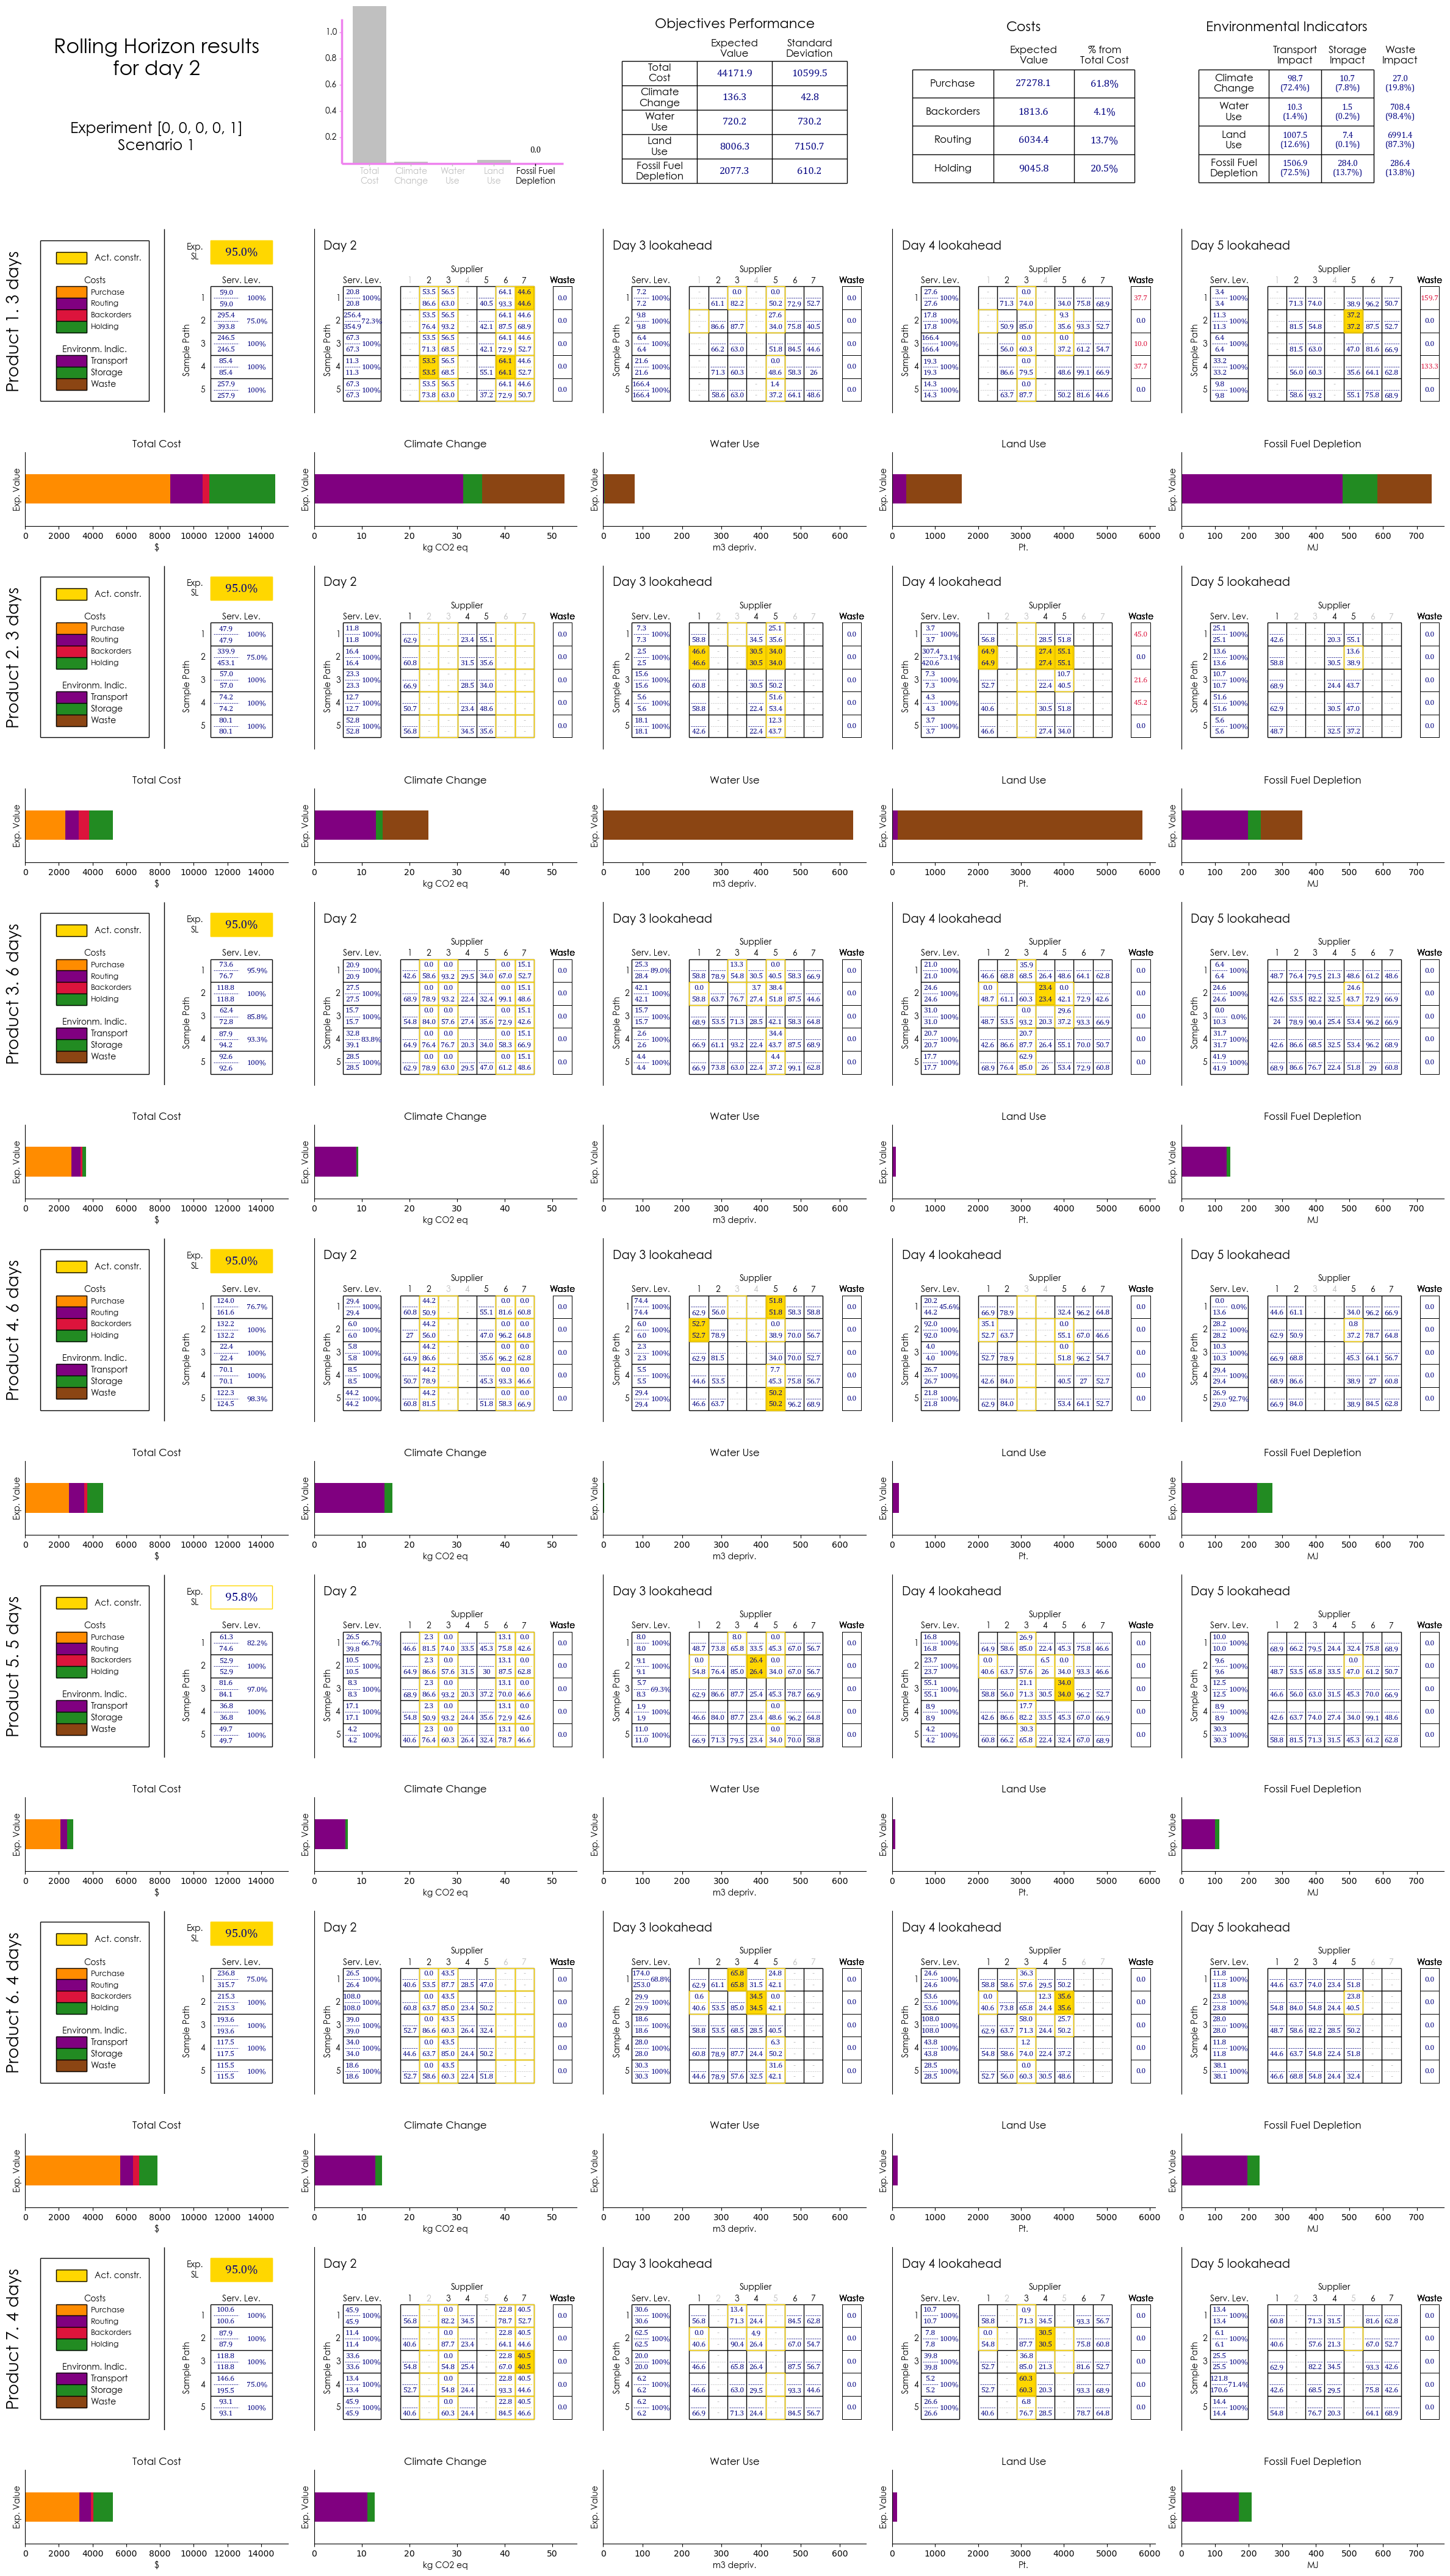

In [13]:
w = [0,0,0,0,1]; day=2
plot_RH_results_by_day_and_product(day, w, 1, save=False, other_path=other_path)

In [ ]:
for w in weights:
    for day in range(1,11):
        plot_RH_results_by_day_and_product(day, w, 1, save=True, other_path=other_path)
    print(f"Done weights {w}")

# Decisions

In [28]:
w = [1,0,0,0,0]

def load_data_by_day(t,weights,seed_ix):

    inventory = verbose_module.import_results.import_inventory(weights, seed_ix, other_path=True)
    action = verbose_module.import_results.import_actions(weights, seed_ix, other_path=True)
    backorders = verbose_module.import_results.import_backorders(weights, seed_ix, other_path=True)
    perished = verbose_module.import_results.import_perished(weights, seed_ix, other_path=True)
    la_decisions = verbose_module.import_results.import_lookahead_decisions(weights, seed_ix, other_path=True); la_decisions = la_decisions[t]
    rewards = verbose_module.import_results.import_rewards(weights, seed_ix, other_path=True)
    inst_gen = verbose_module.import_results.import_instance_parameters(weights, seed_ix, other_path=True)

    inventory = {tt:inventory[tt+1] for tt in range(t+1)}
    purchase = {tt:action[tt+1]["purchase"] for tt in range(t)}; routing = {tt:action[tt+1]["routing"] for tt in range(t)}; demand_compliance = {tt:action[tt+1]["demand_compliance"] for tt in range(t)} 
    backorders = {tt:backorders[tt+1] for tt in range(t)}

    rewards = {tt:rewards[tt+1] for tt in range(t)}
    perished = {tt:perished[tt+1] for tt in range(t)}

    return inventory, purchase, routing, demand_compliance, backorders, perished, la_decisions, rewards, inst_gen

def plot_decisions_by_product(day,k,weights,seed_ix,axes):

    cols = {"inventory":"forestgreen","purchase":"darkorange","backorders":"crimson"}

    inventory, purchase, routing, demand_compliance, backorders, perished, (la_I, la_z, la_b, la_y, la_w), rewards, inst_gen = load_data_by_day(day,weights,seed_ix)

    '''
        Barcharts
    '''
    for t in range(day):
        if t+1 == day: offset = -0.2; width = 0.4
        else: offset = 0; width = 0.8
        tot_stock = sum(inventory[t][k,o] for o in range(1,inst_gen.O_k[k]+1))
        tot_purch = sum(purchase[t][i,k] for i in inst_gen.M_kt[k,t])
        axes[0].bar(x=t+1+offset, width = width, height=tot_stock, color=cols["inventory"])
        axes[0].bar(x=t+1+offset, width = width, height=tot_purch, bottom = tot_stock, color=cols["purchase"])
        axes[0].bar(x=t+1+offset, width = width, height=backorders[t][k], bottom = tot_stock+tot_purch, color=cols["backorders"])
    axes[0].plot(range(1,day+1), [inst_gen.W_d[t][k] for t in range(day)],  marker="*", linestyle="-", color="black", markersize=10)
    
    for t in range(inst_gen.sp_window_sizes[day-1]):
        if t == 0: offset = +0.2; width = 0.4
        else: offset = 0; width = 0.8
        exp_stock = sum(la_I[t-1][s][k,o-1] if t > 0 else inventory[day-1][k,o] for o in range(1,inst_gen.O_k[k]+1) for s in inst_gen.Samples)/len(inst_gen.Samples)
        exp_purch = sum(la_z[t][s][i,k] for i in inst_gen.M_kt[k,day-1] for s in inst_gen.Samples)/len(inst_gen.Samples)
        exp_backo = sum(la_b[t][s][k] for s in inst_gen.Samples)/len(inst_gen.Samples)
        axes[0].bar(x=t+day+offset, width = width, height=exp_stock, color=cols["inventory"], alpha=0.7)
        axes[0].bar(x=t+day+offset, width = width, height=exp_purch, bottom=exp_stock, color=cols["purchase"], alpha=0.7)
        axes[0].bar(x=t+day+offset, width = width, height=exp_backo, bottom=exp_stock+exp_purch, color=cols["backorders"], alpha=0.7)

    ticks = list(range(1,day+1))
    axes[0].set_xticks(ticks); axes[0].set_xticklabels([i for i in ticks], fontname="Cambria", fontsize=14)
    axes[0].set_xlim(0.5,inst_gen.T+0.5); axes[0].set_ylabel(f"Product {k}", fontname="Century Gothic", fontsize=16)

    '''
        Supply Information
    '''
    lim = 5+len(inst_gen.Suppliers)
    axes[1].set_yticks([]); axes[1].set_xticks([]); axes[1].set_ylim(0.5,15); axes[1].set_xlim(0.5,lim-0.5)
    axes[1].text(x=lim/2, y = 14, s=f"Supply", va="center", ha="center", fontname="Century Gothic", fontsize=12)

    axes[1].text(x=(4+lim-1)/2,y=12.5,s="Supplier",va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=2.5, y=10.5, s="Exp. Avail.",va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=2.5, y=9.5, s="St. Dev.",va="center",ha="center",fontname="Century Gothic")
    for i in inst_gen.Suppliers:
        if i in inst_gen.M_kt[k,day-1]: col = "navy"
        else: col = "silver"
        axes[1].text(x = 3.5+i , y = 11.5, s=i, va="center", ha="center", fontname="Century Gothic", color= "black" if col == "navy" else col)
        axes[1].text(x = 3.5+i , y = 10.5, s=round(sum(inst_gen.s_paths_q[day-1][0,s][i,k] for s in inst_gen.Samples)/len(inst_gen.Samples),1) if col != "silver" else "-", va="center", ha="center", fontname="Cambria", color= col, fontsize=9.5)
        axes[1].text(x = 3.5+i , y = 9.5, s=round(np.std([inst_gen.s_paths_q[day-1][0,s][i,k] for s in inst_gen.Samples],ddof=1),1) if col != "silver" else "-", va="center", ha="center", fontname="Cambria", color= col, fontsize=9.5)
    axes[1].vlines(x=[4+i for i in range(len(inst_gen.Suppliers)+1)],ymin=9,ymax=12,color="black",linewidth=1)
    axes[1].vlines(x=[1], ymin=9, ymax = 11, color ="black", lw=1)
    axes[1].hlines(y=[9,11], xmin=1, xmax = lim-1, color = "black", lw=1)
    axes[1].hlines(y=[12], xmin=4, xmax=lim-1, color ="black", lw=1)

    axes[1].text(x=2.5,y=7.5,s="Price",va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=2.5,y=6.5,s="Availability",va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=2.5,y=5.5,s="Purchase",va="center",ha="center",fontname="Century Gothic")
    for i in inst_gen.Suppliers:
        if i in inst_gen.M_kt[k,day-1]: col = "navy"
        else: col = "silver"
        axes[1].text(x = 3.5+i, y=7.5, s = inst_gen.W_p[day-1][i,k] if col != "silver" else "-", va="center", ha="center", fontname="Cambria", color=col, fontsize=9.5)
        axes[1].text(x = 3.5+i, y=6.5, s = inst_gen.W_q[day-1][i,k] if col != "silver" else "-", va="center", ha="center", fontname="Cambria", color=col, fontsize=9.5)
        axes[1].text(x = 3.5+i, y=5.5, s = round(purchase[day-1][i,k],1) if col != "silver" else "-", va="center", ha="center", fontname="Cambria", color=col, fontsize=9.5)
    axes[1].vlines(x=[4+i for i in range(len(inst_gen.Suppliers)+1)],ymin=5,ymax=8,color="black",linewidth=1)
    axes[1].vlines(x=[1], ymin=5, ymax = 8, color ="black", lw=1)
    axes[1].hlines(y=[5,8], xmin=1, xmax = lim-1, color = "black", lw=1)
    
    axes[1].text(x=2.5,y=2.5,s="Purchase",va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=2.5,y=1.5,s="Routing",va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=(4+(4+lim-1)/2)/2, y = 3.5, s="Day", va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=(4+(4+lim-1)/2)/2, y = 2.5, s=round(rewards[day-1]["purchase cost"][k],1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[1].text(x=(4+(4+lim-1)/2)/2, y = 1.5, s=round(rewards[day-1]["transport cost"][k],1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[1].text(x=(lim-1+(4+lim-1)/2)/2, y = 3.5, s="Total", va="center",ha="center",fontname="Century Gothic")
    axes[1].text(x=(lim-1+(4+lim-1)/2)/2, y = 2.5, s=round(sum(rewards[tt]["purchase cost"][k] for tt in range(day)),1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[1].text(x=(lim-1+(4+lim-1)/2)/2, y = 1.5, s=round(sum(rewards[tt]["transport cost"][k] for tt in range(day)),1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[1].vlines(x=[4,(lim-1+4)/2,lim-1],ymin=1,ymax=4,color="black",linewidth=1)
    axes[1].vlines(x=[1], ymin=1, ymax = 3, color ="black", lw=1)
    axes[1].hlines(y=[1,3], xmin=1,xmax=lim-1, color ="black", lw=1)
    axes[1].hlines(y=[4], xmin=4, xmax=lim-1, color="black", lw=1)

    axes[1].spines[["bottom","top","left","right"]].set_visible(False)
    
    '''
        Warehouse Information
    '''
    axes[2].set_yticks([]); axes[2].set_xticks([]); axes[2].set_ylim(0.5,15); axes[2].set_xlim(0.5,9.5)
    axes[2].text(x = 5, y = 14, s=f"Warehouse", va="center", ha="center", fontname="Century Gothic", fontsize=12)

    axes[2].text(x=4, y=12.5, s="Initial", va="center", ha="center", fontname="Century Gothic")
    axes[2].text(x=6, y=12.5, s="Fulfillm.", va="center", ha="center", fontname="Century Gothic")
    axes[2].text(x=8, y=12.5, s="Final", va="center", ha="center", fontname="Century Gothic")
    axes[2].text(x=1.5, y = 8.5, s="Ages", rotation=90, va="center", ha="center", fontname="Century Gothic")
    for o in range(7):
        if o <= inst_gen.O_k[k]:
            col = "navy"
            axes[2].text(x=2.5, y = 11.5-o, s=o, color="black", va="center", ha="center", fontname="Century Gothic")
            axes[2].text(x=4, y = 11.5-o, s=round(inventory[day-1][k,o],1) if o > 0 else round(sum(purchase[day-1][i,k] for i in inst_gen.M_kt[k,day-1]),1), color=col if o > 0 else "forestgreen", va="center", ha="center", fontname="Cambria")
            axes[2].text(x=6, y = 11.5-o, s=round(demand_compliance[day-1][k,o],1), color=col, va="center", ha="center", fontname="Cambria")
            axes[2].text(x=8, y = 11.5-o, s=round(inventory[day][k,o+1],1) if o < inst_gen.O_k[k] else round(perished[day-1][k],1), color=col if o < inst_gen.O_k[k] else "crimson", va="center", ha="center", fontname="Cambria")
        else:
            col = "silver"
            axes[2].text(x=2.5, y = 11.5-o, s=o, color=col, va="center", ha="center", fontname="Century Gothic")
            axes[2].text(x=4, y = 11.5-o, s= "-", color=col if o > 0 else "silver", va="center", ha="center", fontname="Century Gothic")
            axes[2].text(x=6, y = 11.5-o, s= "-", color=col, va="center", ha="center", fontname="Century Gothic")
            axes[2].text(x=8, y = 11.5-o, s= "-", color=col, va="center", ha="center", fontname="Century Gothic")
    axes[2].vlines(x=[3,9], ymin=5+6-inst_gen.O_k[k], ymax = 13, lw=1, color="black")
    axes[2].vlines(x=[2], ymin=5+6-inst_gen.O_k[k], ymax = 12, lw=1, color="black")
    axes[2].hlines(y=[5+6-inst_gen.O_k[k]+i for i in range(12-5-6+inst_gen.O_k[k]+1)], xmin=2, xmax=9,lw=1, color="black")
    axes[2].hlines(y=[13], xmin=3, xmax=9,lw=1, color="black")
    if inst_gen.O_k[k] < 6:
        axes[2].vlines(x=[2,3,5,7,9], ymin=5, ymax=5+6-inst_gen.O_k[k], color="silver", lw=1)
        axes[2].hlines(y=[5+i for i in range(6-inst_gen.O_k[k])], xmin=2, xmax = 9, color="silver", lw=1)

    axes[2].text(x=2.5,y=2.5,s="Perished",va="center",ha="center",fontname="Century Gothic")
    axes[2].text(x=2.5,y=1.5,s="Holding",va="center",ha="center",fontname="Century Gothic")
    axes[2].text(x=(4+6.5)/2, y = 3.5, s="Day", va="center",ha="center",fontname="Century Gothic")
    axes[2].text(x=(4+6.5)/2, y = 2.5, s=round(perished[day-1][k],1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[2].text(x=(4+6.5)/2, y = 1.5, s=round(rewards[day-1]["holding cost"][k],1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[2].text(x=(6.5+9)/2, y = 3.5, s="Total", va="center",ha="center",fontname="Century Gothic")
    axes[2].text(x=(6.5+9)/2, y = 2.5, s=round(sum(perished[tt][k] for tt in range(day)),1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[2].text(x=(6.5+9)/2, y = 1.5, s=round(sum(rewards[tt]["holding cost"][k] for tt in range(day)),1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[2].vlines(x=[4,6.5,9],ymin=1,ymax=4,color="black",linewidth=1)
    axes[2].vlines(x=[1], ymin=1, ymax = 3, color ="black", lw=1)
    axes[2].hlines(y=[1,3], xmin=1,xmax=9, color ="black", lw=1)
    axes[2].hlines(y=[4], xmin=4, xmax=9, color="black", lw=1)

    axes[2].spines[["bottom","top","left","right"]].set_visible(False)

    '''
        Demand Information
    '''
    axes[3].set_yticks([]); axes[3].set_xticks([]); axes[3].set_ylim(0.5,15); axes[3].set_xlim(0.5,8.5)
    axes[3].text(x=4.5, y = 14, s=f"Demand", va="center", ha="center", fontname="Century Gothic", fontsize=12)

    axes[3].text(x=5, y = 11.5, s=f"Day", va="center", ha="center", fontname="Century Gothic")
    axes[3].text(x=2.5, y=10.5, s="Exp. Dem.",va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=2.5, y=9.5, s="St. Dev.",va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=5, y=10.5, s=round(sum(inst_gen.s_paths_d[day-1][0,s][k] for s in inst_gen.Samples)/len(inst_gen.Samples),1), va="center", ha="center", fontname="Cambria", color="navy")
    axes[3].text(x=5, y=9.5, s=round(np.std([inst_gen.s_paths_d[day-1][0,s][k] for s in inst_gen.Samples],ddof=1),1), va="center", ha="center", fontname="Cambria", color="navy")
    axes[3].vlines(x=[4, 6], ymin=9,ymax=12,color="black",linewidth=1)
    axes[3].vlines(x=[1], ymin=9, ymax = 11, color ="black", lw=1)
    axes[3].hlines(y=[9,11], xmin=1, xmax = 6, color = "black", lw=1)
    axes[3].hlines(y=[12], xmin=4, xmax=6, color ="black", lw=1)

    axes[3].text(x=2.5,y=7.5,s="Demand",va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=2.5,y=6.5,s="Fulfillm.",va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=2.5,y=5.5,s="Backorders",va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=5, y=7.5, s=round(inst_gen.W_d[day-1][k],1), va="center", ha="center", fontname="Cambria", color="navy")
    axes[3].text(x=5, y=6.5, s=round(sum(demand_compliance[day-1][k,o] for o in range(inst_gen.O_k[k]+1)),1), va="center", ha="center", fontname="Cambria", color="navy")
    axes[3].text(x=5, y=5.5, s=round(backorders[day-1][k],1), va="center", ha="center", fontname="Cambria", color="navy")
    axes[3].vlines(x=[4, 6],ymin=5,ymax=8,color="black",linewidth=1)
    axes[3].vlines(x=[1], ymin=5, ymax = 8, color ="black", lw=1)
    axes[3].hlines(y=[5,8], xmin=1, xmax = 6, color = "black", lw=1)
    
    axes[3].text(x=2.5,y=2.5,s="Serv. Lev.",va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=2.5,y=1.5,s="Backorders",va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=5, y = 3.5, s="Day", va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=5, y = 2.5, s=f"{sum(demand_compliance[day-1][k,o] for o in range(inst_gen.O_k[k]+1))/inst_gen.W_d[day-1][k]:.1%}", va="center",ha="center",fontname="Cambria", color="navy")
    axes[3].text(x=5, y = 1.5, s=round(rewards[day-1]["backorders cost"][k],1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[3].text(x=7, y = 3.5, s="Total", va="center",ha="center",fontname="Century Gothic")
    axes[3].text(x=7, y = 2.5, s=f"{sum(demand_compliance[tt][k,o] for o in range(inst_gen.O_k[k]+1) for tt in range(day))/sum(inst_gen.W_d[tt][k] for tt in range(day)):.1%}", va="center",ha="center",fontname="Cambria", color="navy")
    axes[3].text(x=7, y = 1.5, s=round(sum(rewards[tt]["backorders cost"][k] for tt in range(day)),1), va="center",ha="center",fontname="Cambria", color="navy")
    axes[3].vlines(x=[4,6,8],ymin=1,ymax=4,color="black",linewidth=1)
    axes[3].vlines(x=[1], ymin=1, ymax = 3, color ="black", lw=1)
    axes[3].hlines(y=[1,3], xmin=1,xmax=8, color ="black", lw=1)
    axes[3].hlines(y=[4], xmin=4, xmax=8, color="black", lw=1)

    axes[3].spines[["bottom","top","left","right"]].set_visible(False)

def plot_decisions_by_day(day, weights, seed_ix):

    inst_gen = verbose_module.import_results.import_instance_parameters(weights, seed_ix, other_path=True)

    fig, axes = plt.subplots(ncols=4,nrows=len(inst_gen.Products),figsize=(20,4*len(inst_gen.Products)),width_ratios=[2,1.4,0.8,0.8])
    fig.subplots_adjust(wspace= 0.1)

    lim = 0
    for k in inst_gen.Products:
        plot_decisions_by_product(day, k, weights, seed_ix, axes[k-1])
        lim = np.max([lim,axes[k-1][0].get_ylim()[1]])
    
    for k in inst_gen.Products:
        axes[k-1][0].set_ylim(0,lim)



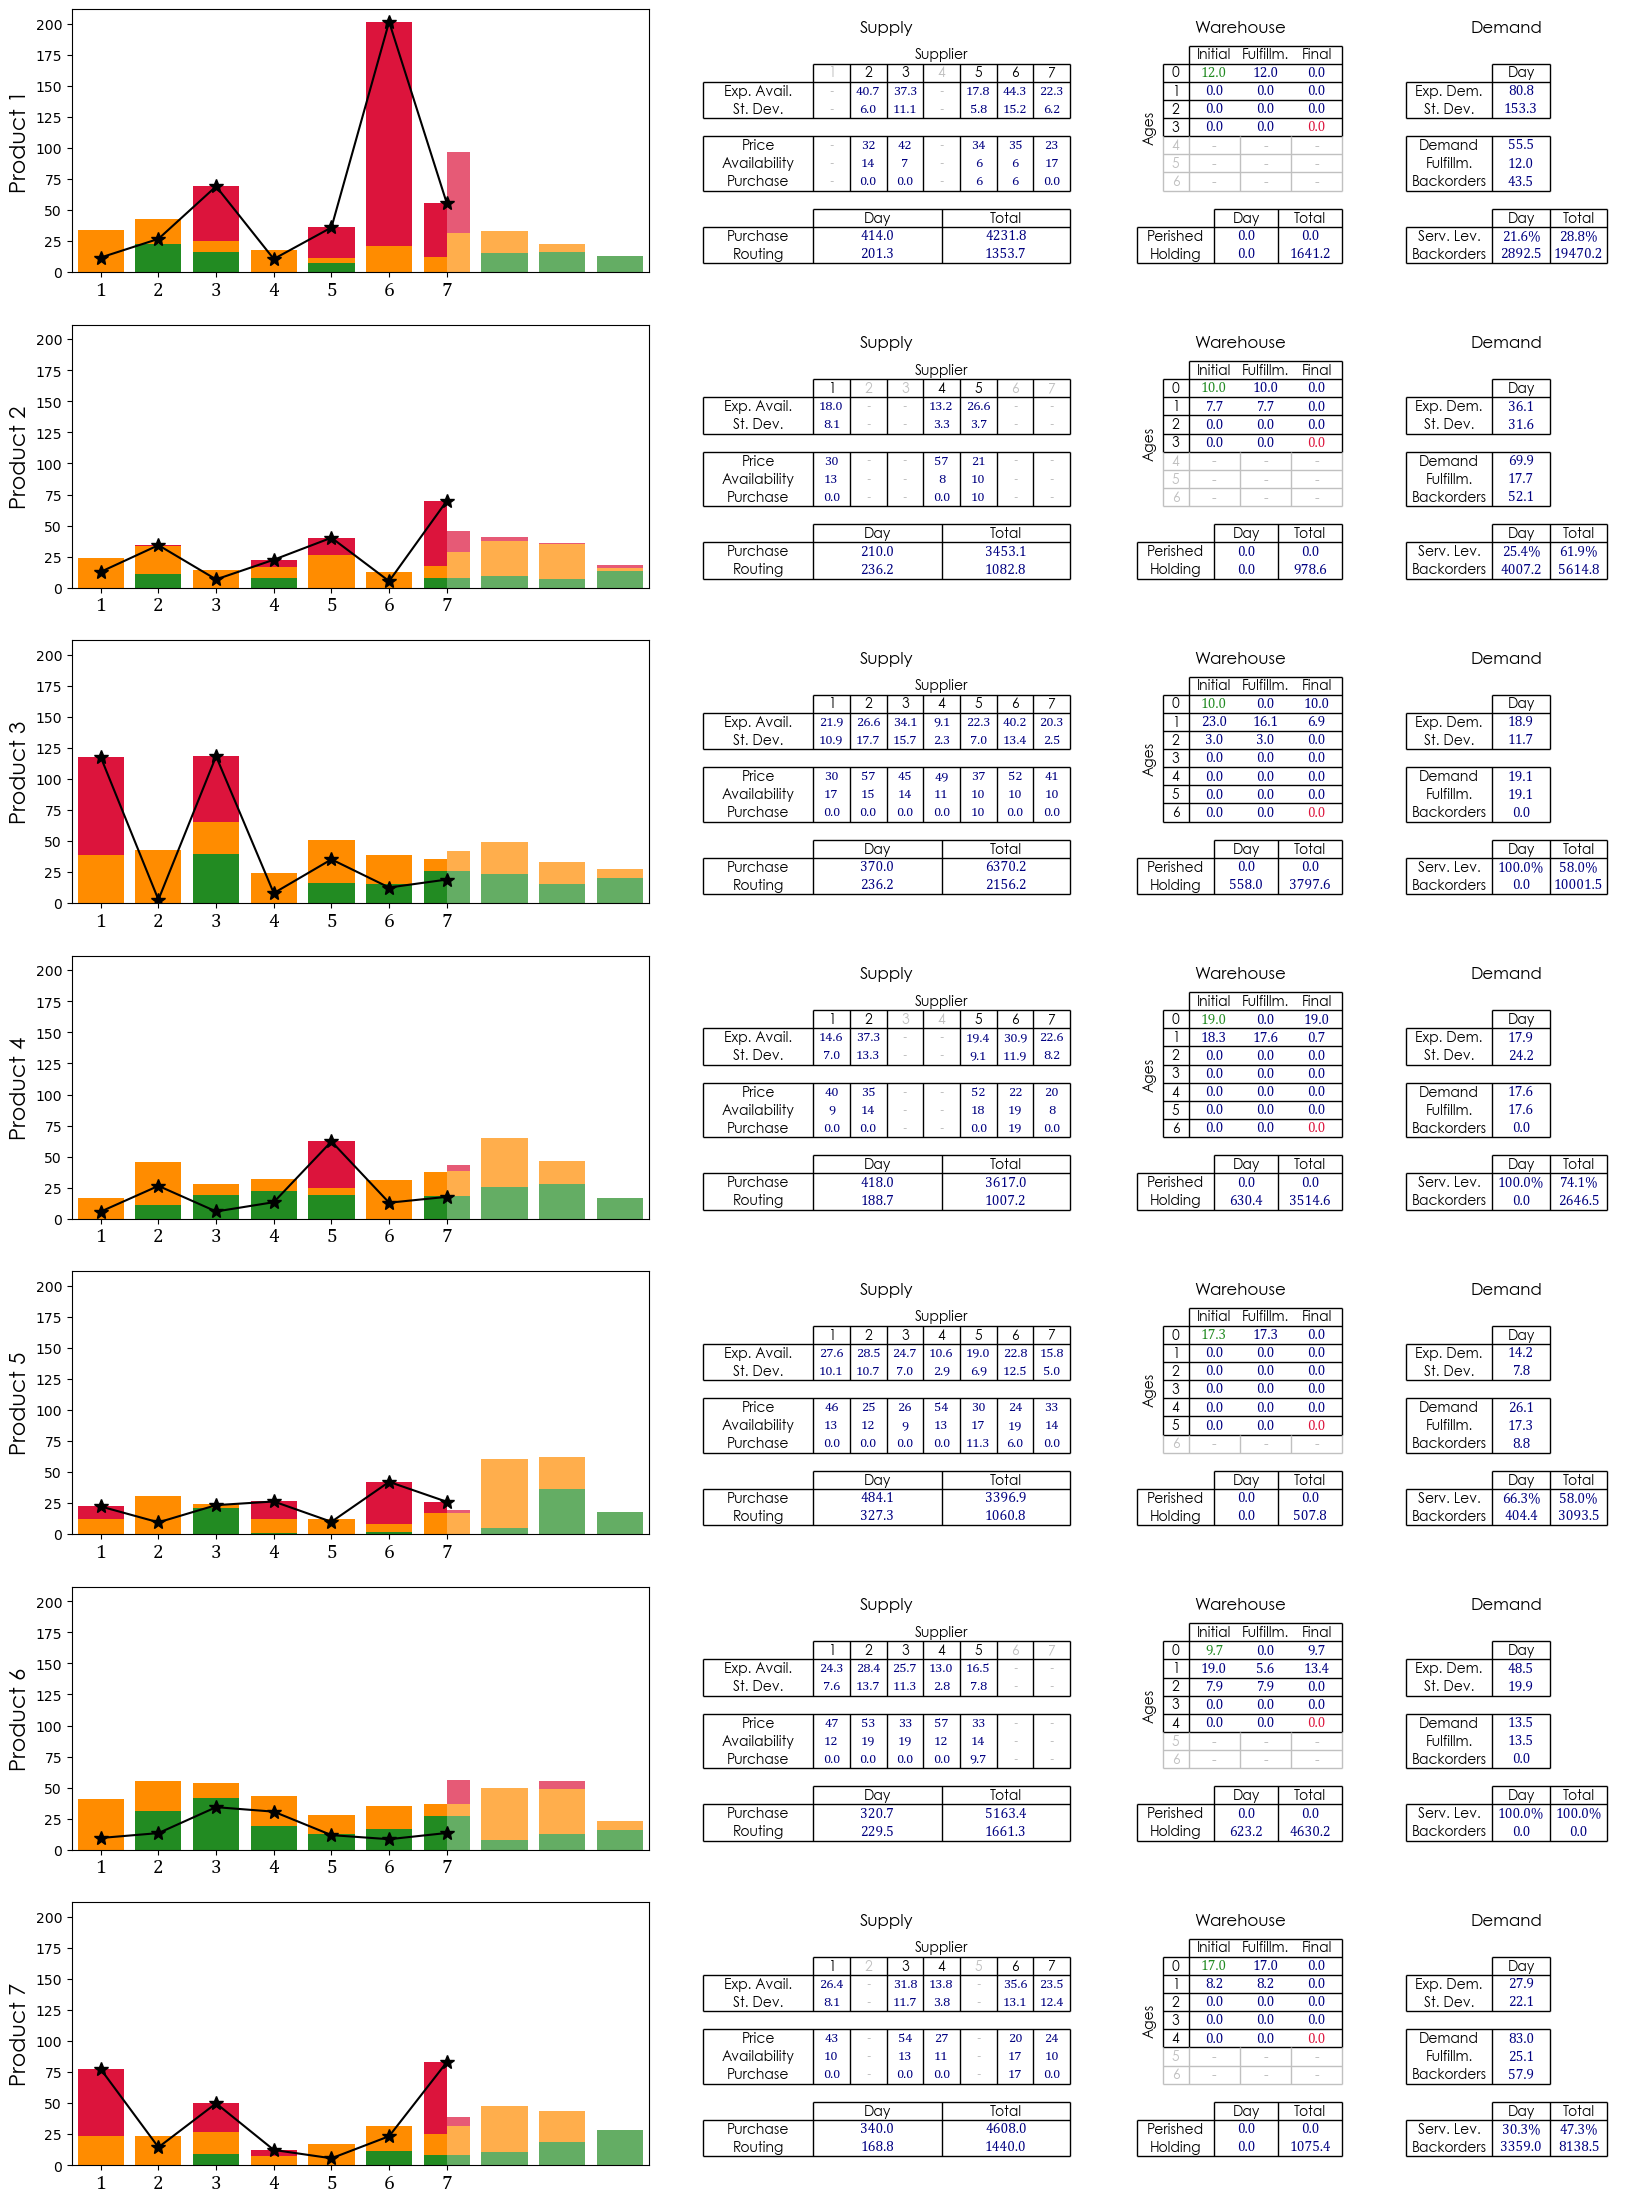

In [29]:
plot_decisions_by_day(day = 7, weights = w, seed_ix = 1)

# Rewards

In [51]:
def import_rewards(w):

    rewards = dict()
    for it in range(1,8):
        file = open(f"C:/Users/ari_r/OneDrive - Universidad de los Andes/1. MIIND/Tesis/Experimentos/Rewards/Rewards_{w}/Rewards_{w}_{it}", "rb")
        rewards[it] = load(file); file.close()

    agg_rewards = dict()
    for e in rewards[1][1]:
        agg_rewards[e] = {p:[sum(rewards[it][t][e][p] for t in rewards[1]) for it in rewards] for p in rewards[1][1][e]}
        agg_rewards[e]["total"] = [sum(rewards[it][t][e][p] for t in rewards[1] for p in rewards[1][1][e]) for it in rewards]
    
    return agg_rewards

def get_rewards_and_sets(w1,w2):

    base = import_rewards(w1); policy = import_rewards(w2)
    E = list(base.keys()); P = list(base["transport cost"].keys()); I = list(range(len(base["transport cost"][1])))
    metric_names = {"transport cost":"Transportation\nCost", "purchase cost":"Purchasing\nCost", "holding cost":"Holding\nCost", "backorders cost":"Backorders\nCost",
                    "climate":"Climate\nChange", "water":"Water\nUse", "land":"Land\nUse", "fossil":"Fossil Fuel\nDepletion"}

    return base, policy, I, E, P, metric_names

def compute_total_cost_differences(base, policy, E, P, I):

    tc_base = [sum(base[e][p][it] for e in E[:4] for p in P) for it in I]
    tc_policy = [sum(policy[e][p][it] for e in E[:4] for p in P) for it in I]

    return tc_base, tc_policy

def compute_relative_performance(base,policy, P, I, metrics = ["transport cost", "purchase cost", "holding cost", "backorders cost"]):

    def avg_relative_performance(e):

        perf = {p:sum([policy[e][p][it]/base[e][p][it] - 1 for it in I])/len(I) for p in P}
        perf["total"] = sum([sum(policy[e][p][it] for p in P)/sum(base[e][p][it] for p in P) - 1 for it in I])/len(I)

        return perf

    performances = {e:avg_relative_performance(e) for e in metrics}

    return performances


def ttest_mean_difference(sample1, sample2, sign_level = 0.05):

    t_statistic, p_value = ttest_rel(sample1, sample2)
    if p_value < sign_level: resp = 1
    else: resp = 0

    return resp

def mean_difference(base, policy, P, sign_level = 0.05, metrics = ["transport cost", "purchase cost", "holding cost", "backorders cost"]):

    significance = dict()
    for e in metrics:
        significance[e] = dict()
        for p in P+["total"]:
            significance[e][p] = ttest_mean_difference(base[e][p], policy[e][p], sign_level=sign_level)

    return significance

def normalize_performances(base, policy, I, E):

    max_vals = {e:np.max((sum(base[e]["total"][it] for it in I)/len(I),sum(policy[e]["total"][it] for it in I)/len(I))) for e in E}
    norm_base = {e:sum(base[e]["total"][it] for it in I)/(len(I)*max_vals[e]) for e in E}
    norm_policy = {e:sum(policy[e]["total"][it] for it in I)/(len(I)*max_vals[e]) for e in E}

    return norm_base, norm_policy

def sustainability_evaluation(w2, w1 = [1,0,0,0,0], sign_level = 0.05, aggregated = True):

    base, policy, I, E, P, names = get_rewards_and_sets(w1, w2)
    
    sign_perf = mean_difference(base,policy, P, sign_level = sign_level, metrics = E)
    avg_rel_perf = compute_relative_performance(base, policy, P, I, metrics = E)

    norm_base, norm_policy = normalize_performances(base, policy, I, E)
    tc_base, tc_policy = compute_total_cost_differences(base, policy, E, P, I)
    tc_sign = ttest_mean_difference(tc_base, tc_policy, sign_level=sign_level)

    fig, (ax2, ax1) = plt.subplots(nrows = 1, ncols=2, figsize=(16,8))
    fig.subplots_adjust(hspace=0.1, wspace=0.025)

    ''' Radar plot '''

    circles = [Circle((0,0),5-i,edgecolor="gray",facecolor="white") for i in range(5)]
    for c in circles: ax1.add_patch(c)
    delta = np.pi/8
    for i in range(4): ax1.plot([-5*np.cos(delta+i*np.pi/4),5*np.cos(delta+i*np.pi/4)],[-5*np.sin(delta+i*np.pi/4),5*np.sin(delta+i*np.pi/4)],linestyle="-",color="silver")

    for j in range(len(E)):
        angle = 11*delta - j*np.pi/4
        ax1.text(x=5*np.cos(angle)+np.sign(np.cos(angle)), y=5*np.sin(angle)+np.sign(np.sin(angle)) , s=names[E[j]], va="center", ha="center", fontname="Century Gothic")
        if j < len(E)-1:
            ax1.plot([5*norm_base[E[j]]*np.cos(angle),5*norm_base[E[j+1]]*np.cos(angle-np.pi/4)],[5*norm_base[E[j]]*np.sin(angle),5*norm_base[E[j+1]]*np.sin(angle-np.pi/4)], marker="o", color="gold", markersize=10)
            ax1.plot([5*norm_policy[E[j]]*np.cos(angle),5*norm_policy[E[j+1]]*np.cos(angle-np.pi/4)],[5*norm_policy[E[j]]*np.sin(angle),5*norm_policy[E[j+1]]*np.sin(angle-np.pi/4)], marker="D", color="dodgerblue", markersize=10)
        else:
            ax1.plot([5*norm_base[E[-1]]*np.cos(angle),5*norm_base[E[0]]*np.cos(angle-np.pi/4)],[5*norm_base[E[-1]]*np.sin(angle),5*norm_base[E[0]]*np.sin(angle-np.pi/4)], marker="o", color="gold", markersize=10)
            ax1.plot([5*norm_policy[E[-1]]*np.cos(angle),5*norm_policy[E[0]]*np.cos(angle-np.pi/4)],[5*norm_policy[E[-1]]*np.sin(angle),5*norm_policy[E[0]]*np.sin(angle-np.pi/4)], marker="D", color="dodgerblue", markersize=10)

    ax1.spines[["bottom","top","left","right"]].set_visible(False)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax1.set_ylim(-7,7); ax1.set_xlim(-7,7)  

    thick = 1
    ax2.vlines(x=[1]+[5+2*i for i in range(8)]+[22],ymin=2,ymax=6,color="black",lw=thick)
    ax2.vlines(x=[1]+[5+2*i for i in range(8)]+[22],ymin=7,ymax=11,color="black",lw=thick)
    ax2.vlines(x=[5+2*i for i in range(8)]+[22],ymin=12,ymax=14,color="black",lw=thick)
    ax2.vlines(x=[19,22], ymin=1, ymax=2, color="black",lw=thick)

    ax2.hlines(y=[2+i for i in range(10)], xmin=1, xmax=22, color="black",lw=thick)
    ax2.hlines(y=[12,14], xmin=5, xmax=22, color="black",lw=thick)
    ax2.hlines(y=[1], xmin=19, xmax=22, color="black",lw=thick)

    ax2.text(x=20.5, y=13, s="Total", va="center", ha="center", fontname="Century Gothic", weight="bold", fontsize=13)
    
    ix = 0
    for e in ["climate","water","land","fossil"]:
        ax2.text(x=3, y=10.5-ix, s=names[e], va="center", ha="center", fontname="Century Gothic",fontsize=10)
        ixp = 0
        for p in P[:-1]:
            if sign_perf[e][p]:
                if np.sign(avg_rel_perf[e][p]): color="crimson"
                else: color="forestgreen"
            else:
                color="black"
            ax2.text(x=6+ixp, y=10.5-ix, s=f"{avg_rel_perf[e][p]:+.1%}"+"*"*sign_perf[e][p], va="center", ha="center", color=color, fontname="Cambria", fontsize=9); ixp+=2
        if sign_perf[e]["total"]:
            if np.sign(avg_rel_perf[e]["total"]): color="crimson"
            else: color="forestgreen"
        else:
            color="black"
        ax2.text(x=6+ixp+0.5, y=10.5-ix, s=f"{avg_rel_perf[e]['total']:+.1%}"+"*"*sign_perf[e]["total"], va="center", ha="center", color=color, fontname="Cambria", weight="bold", fontsize=11)
        ix += 1
    
    ix = 0
    for e in ["transport cost","purchase cost","holding cost","backorders cost"]:
        ax2.text(x=3, y=5.5-ix, s=names[e], va="center", ha="center", fontname="Century Gothic",fontsize=10)
        ixp = 0
        for p in P[:-1]:
            if sign_perf[e][p]:
                if np.sign(avg_rel_perf[e][p]): color="crimson"
                else: color="forestgreen"
            else:
                color="black"
            ax2.text(x=6+ixp, y=5.5-ix, s=f"{avg_rel_perf[e][p]:+.1%}"+"*"*sign_perf[e][p], va="center", ha="center", color=color, fontname="Cambria", fontsize=9); ixp+=2
        if sign_perf[e]["total"]:
            if np.sign(avg_rel_perf[e]["total"]): color="crimson"
            else: color="forestgreen"
        else:
            color="black"
        ax2.text(x=6+ixp+0.5, y=5.5-ix, s=f"{avg_rel_perf[e]['total']:+.1%}"+"*"*sign_perf[e]["total"], va="center", ha="center", color=color, fontname="Cambria", weight="bold", fontsize=11)
        ix += 1
    total = sum(tc_policy)/sum(tc_base) - 1
    ax2.text(x=20.5, y=1.5, s=f"{total:+.1%}"+"*"*tc_sign, va="center", ha="center", fontname="Cambria", weight="bold", fontsize=12)

    ax2.text(x=1,y=1.25,s=f"Results marked * are significantly different with p = {sign_level}", ha="left", va="center", fontname="Century Gothic", fontsize=10)
    ax2.spines[["bottom","top","left","right"]].set_visible(False)
    ax2.set_xlim(0.75,22.25); ax2.set_ylim(0.5,16)
    ax2.set_xticks([]); ax2.set_yticks([])  


def violins(ax, base, policy):

    facecols = {"base":"gold", "policy":"dodgerblue"}
    edgecols = {"base":"darkorange", "policy":"royalblue"}
    data = pd.DataFrame({"aux":["1"]*len(policy+base),  "pol": ["policy"]*len(policy) + ["base"]*len(base), "val": policy + base})
    violin = sns.violinplot(data=data, x ="val", y="aux", hue="pol", split=True, inner="quart", orient="h", ax=ax)
    for i, (category, violin_part) in enumerate(zip(violin.get_legend().get_texts(), violin.collections)):
        if i % 2 == 0:  # Even indices correspond to the left part of the violin
            violin_part.set_edgecolor(edgecols.get(category.get_text(), 'red'))
            violin_part.set_facecolor((facecols.get(category.get_text()), 0.7))
        else:  # Odd indices correspond to the right pa)rt of the violin
            violin_part.set_edgecolor(edgecols.get(category.get_text(), 'red'))
            violin_part.set_facecolor((facecols.get(category.get_text()), 0.7))
    for i, line in enumerate(ax.lines):
        if i % 8 in [0,1,2]:  # Quartiles lines for the left side of the violin
            line.set_color(edgecols["policy"])  # Change 'blue' to the desired color
        else:  # Quartiles lines for the right side of the violin
            line.set_color(edgecols["base"])  # Change 'yellow' to the desired color

    ax.set_yticks([])
    ax.legend([], [], frameon=False)
    ax.set_ylabel(""); ax.set_xlabel("")
    #ax.xaxis.get_offset_text().set_visible(False)
    
    l, u = ax.get_xlim()
    ticks = [l+(u-l)/10+i*(u-l)/5 for i in range(5)]
    ax.set_xticks(ticks)

def costs_performance(w2, w1 = [1,0,0,0,0], sign_level = 0.05):

    base, policy, I, E, P, names = get_rewards_and_sets(w1, w2)
    
    sign_perf = mean_difference(base,policy, P, sign_level = sign_level, metrics = E)
    avg_rel_perf = compute_relative_performance(base, policy, P, I, metrics = E)

    norm_base, norm_policy = normalize_performances(base, policy, I, E)
    tc_base, tc_policy = compute_total_cost_differences(base, policy, E, P, I)
    tc_sign = ttest_mean_difference(tc_base, tc_policy, sign_level=sign_level)

    fig, axes = plt.subplots(figsize=(12,8)); axes.remove()
    gs = fig.add_gridspec(nrows = 4, ncols= 2, width_ratios=[2,1], wspace=0.1, hspace=0.2)

    ax1 = fig.add_subplot(gs[2:, 0])
    violins(ax1, tc_base, tc_policy)
    
    
    axes = {E[i]:fig.add_subplot(gs[i,1]) for i in range(4)}
    for e in axes:
        violins(axes[e], base[e]["total"], policy[e]["total"])




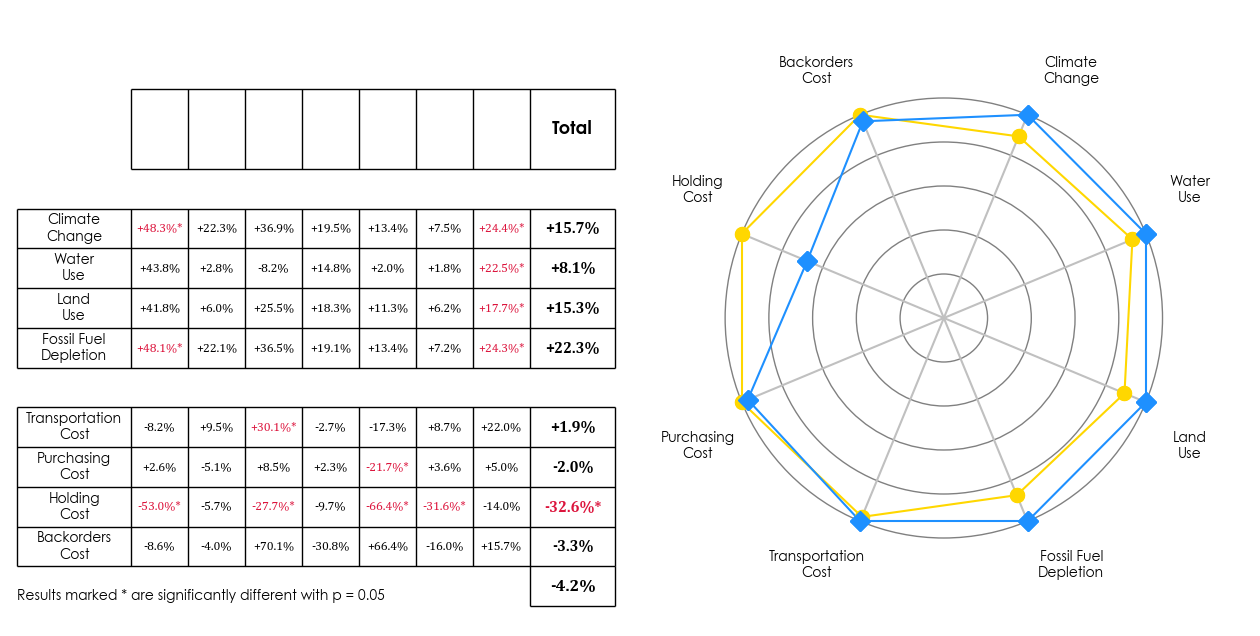

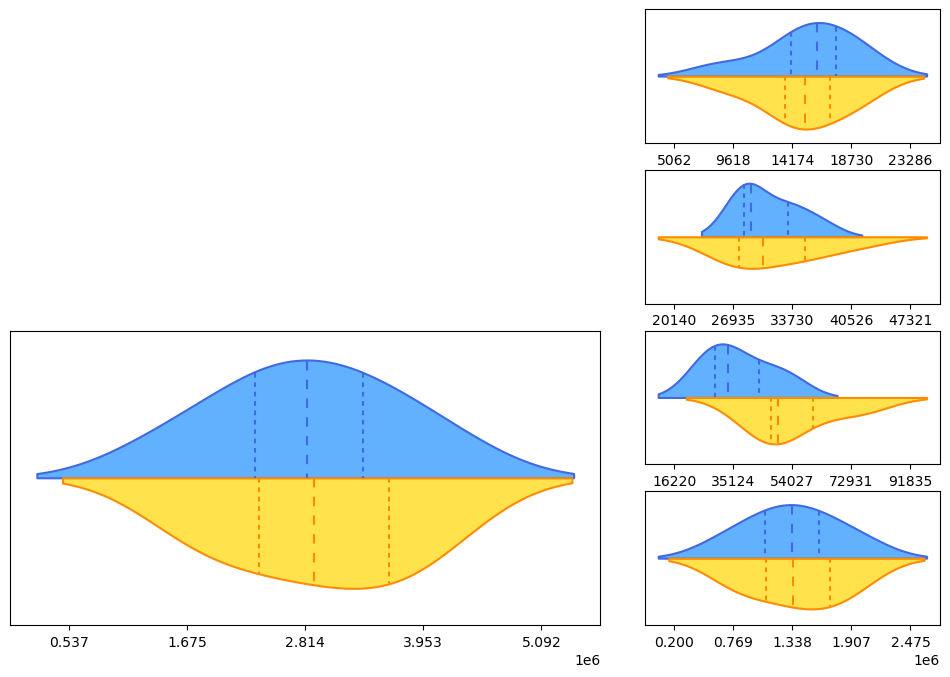

In [52]:
w = [0.5,0.125,0.125,0.125,0.125]
sustainability_evaluation(w)
costs_performance(w)